# Pipeline

### 1. Define ROI

1. 1stLevel_defROI: using all game1 runs of each subject to execute F-test analysis(cos(6*theta) + sin(6*theta))
2. 2ndLeven_defROI: using adult/high performance/all subjects data to execute 2nd one-sample t-test
3. makeMask: find maximum activities voxels of 2nd t-test map in previous ROI to define target ROIs(EC and vmPFC)



### 2. Estimate Phi using a cross-validation approach

1. 1stLevel_estPhi: split 6 runs of game1 into 2 training set to execute F-test analysis(cos(ifold * theta) + sin(ifold * theta)) separately.

2. estPhi:
    - estimate Phi from sin_beta_map, cos_beta_map of two training sets separately.
    - output: train_set1_phi.csv train_set2_phi.csv


3. testPhi_Event: generate the align phi event files according to Phi estimated from different ifold model.

4. 1stLevel_alignPhi: test beta effect of cos6*(theat-Phi) cross the different ifold.

5. extractBeta： extract beta in target ROI across different subjects across different ifold.
                 output: sub_id ifold ec_beta vmpfc_beta

6. plot 5   x= ifold, y= ec_beta / vmpfc_beta

In [37]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from os.path import join as pjoin
import matplotlib.pyplot as plt

from nilearn.image import load_img
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker

#### extract origin activity from ROI based on event file

In [81]:
# extract activity from ROI based on event file

data_root = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume'
sub_id = ['024','068','069']
run_id = 1

func = pjoin(data_root, f'sub-{sub_id}/func/sub-{sub_id}_task-game1_run-{run_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
confounds_file = pjoin(data_root, f'sub-{sub_id}/func/sub-{sub_id}_task-game1_run-{run_id}_desc-confounds_timeseries.tsv')
roi = fr'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/defROI/sub-{sub_id}/vmpfc_func_roi.nii'

func_img = load_img(func)
confounds = pd.read_csv(confounds_file,sep='\t')
roi_img = load_img(roi)

Text(0.5, 1.0, 'sub-069: run-1')

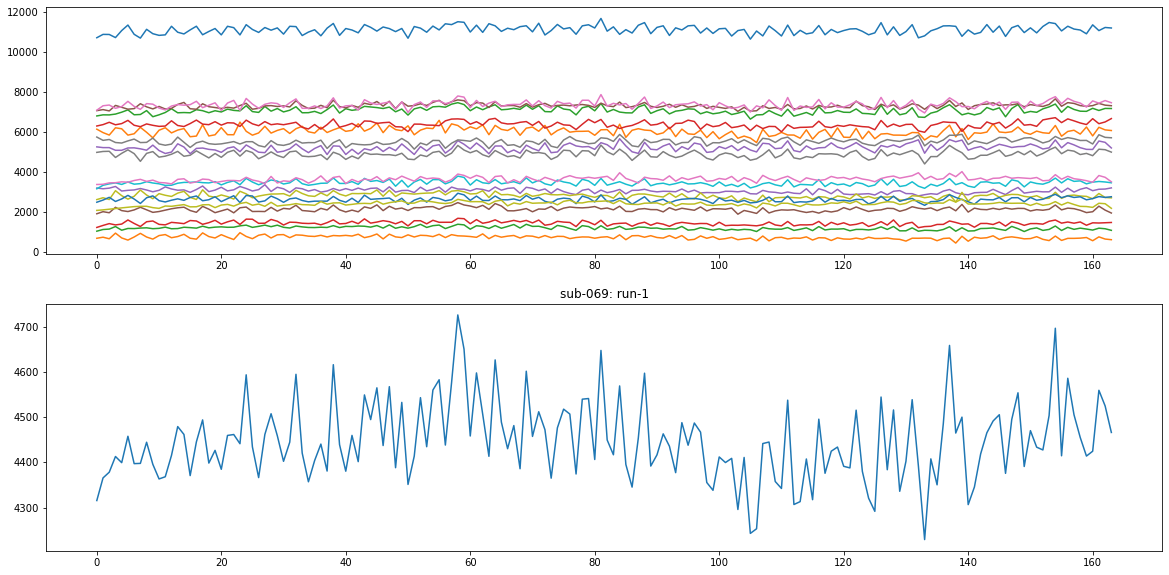

In [95]:
# 1. find a function to extract activity without data cleaning.
activity_series = apply_mask(imgs=func_img, mask_img=roi_img)
fig,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(activity_series)
ax[1].plot(np.nanmean(activity_series,axis=1))
plt.title(f'sub-{sub_id}: run-{run_id}')

#### data cleaning

Text(0.5, 1.0, 'sub-069: run-1')

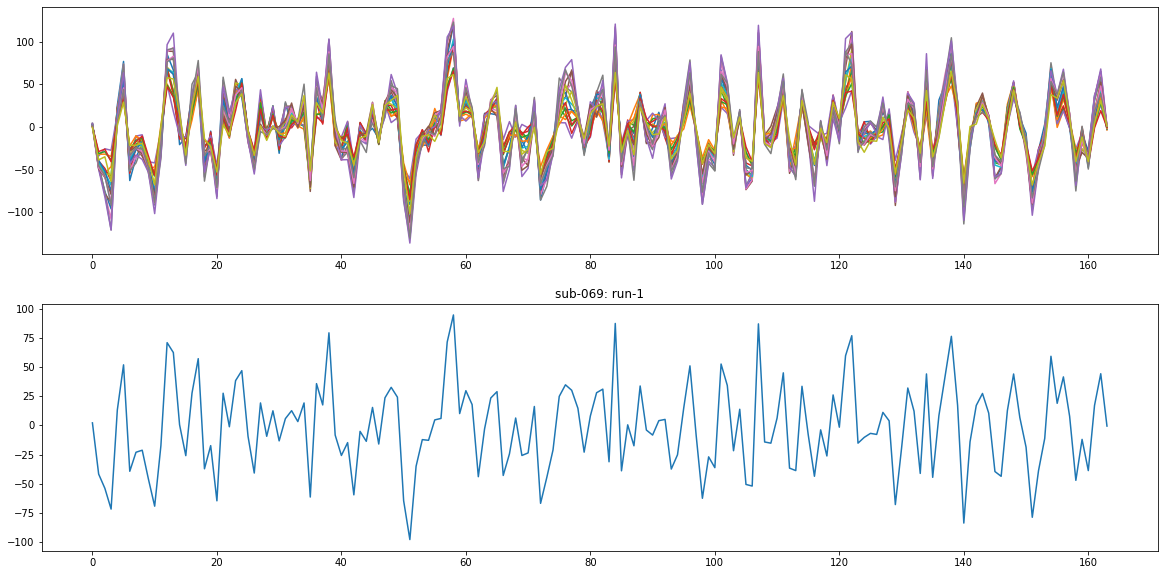

In [96]:
motion_columns = ['trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2',
                  'trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
                  'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
                  'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2',
                  'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
                  'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']
confounds = confounds[motion_columns].copy()
confounds.fillna(0, inplace=True)
brain_masker = NiftiMasker(mask_img=roi_img,smoothing_fwhm=8,high_pass=1/128,t_r=3)
activity_series = brain_masker.fit_transform(func, confounds=confounds)
fig,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(activity_series)
ax[1].plot(np.nanmean(activity_series,axis=1))
plt.title(f'sub-{sub_id}: run-{run_id}')

#### extract bold signal on the time from M2 to t end of trial